In [2]:
# %matplotlib ipympl

In [3]:
import torch
import numpy as np
import importlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from time import sleep, time
import sys
import os
DatasetPath = '../Dataset/' 
# append absolute DasetPath to path
DatasetPath = os.path.abspath(DatasetPath)
sys.path.append(DatasetPath)
import Dataset2 as DS

import pandas as pd

importlib.reload(DS)
DatasetContainer = DS.DatasetContainer
ProcessingDatasetContainer = DS.ProcessingDatasetContainer

def PLTParams(figsize = [10,10]):
    plt.rcParams['figure.figsize']=figsize
    plt.rcParams['font.size']=15
PLTParams()



sys.path.append(os.path.abspath('../CherenkovFraction/'))

# Add the ignore warnings
import warnings
warnings.filterwarnings("ignore")


In [4]:
def IndexToXY(indices,return_tensor=False):
    indices = indices -1
    Xs = indices//22
    Ys = indices%22
    if return_tensor: return Xs.int(),Ys.int()
    else:             return Xs.int().tolist(),Ys.int().tolist()



### Import Datasets

In [5]:
DataPath = os.path.abspath('../Data/Proccessed/')
print('DataPath:',DataPath)

DataPath: /home/fedor-tairli/work/CDEs/Data/Proccessed


In [6]:
# Importing Dataset
# Cause it takes a while to lad this thing introduce a check if its already laoded into globals
CheckGlobals = True 
LoadTraces = True

if CheckGlobals: 
    if 'Dataset' in globals():
        print('Dataset already loaded')
        if len(Dataset.Event_level_keys.keys())<1:
            print('Dataset Event_level_keys is None, reloading Dataset')
            Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)
    else:
        print('Loading Dataset')
        Dataset = DatasetContainer()
        Dataset.Load(DataPath,'CDEsDataset' ,LoadTraces=LoadTraces)

# Unfuck the Dataset Keys, cuase the EventID string should have a capital D....
if 'EventId_1/2' in Dataset.Event_level_keys.keys():
    Dataset.Event_level_keys['EventID_1/2'] = Dataset.Event_level_keys.pop('EventId_1/2')
    Dataset.Event_level_keys['EventID_2/2'] = Dataset.Event_level_keys.pop('EventId_2/2')
    print('Replaced the EventID Keys, with proper ones')
else:
    print('EventID Keys already replaced')

Loading Dataset
Loading CDEsDataset
EventID Keys already replaced


In [7]:
print('Event level keys:')
for key in Dataset.Event_level_keys.keys(): print('    ',key)
print('Pixel level keys:')
for key in Dataset.Pixel_level_keys.keys(): print('    ',key)

Event level keys:
     EventID_1/2
     EventID_2/2
     Rec_Level
     Event_Class
     Primary
     Gen_LogE
     Gen_CosZenith
     Gen_Xmax
     Gen_dEdXmax
     Gen_SDPPhi
     Gen_SDPTheta
     Gen_Chi0
     Gen_Rp
     Gen_T0
     Gen_CoreEyeDist
     Gen_CherenkovFraction
     Rec_LogE
     Rec_CosZenith
     Rec_Xmax
     Rec_dEdXmax
     Rec_SDPPhi
     Rec_SDPTheta
     Rec_Chi0
     Rec_Rp
     Rec_T0
     Rec_CoreEyeDist
     Rec_CherenkovFraction
Pixel level keys:
     PixelID
     TelID
     EyeID
     Status
     Charge
     Theta
     Phi
     TimeOffset
     PulseStart
     PulseCentroid
     PulseStop


In [8]:
AllPossiblePixelDirections = pd.read_csv('../ReadingData/camera_view_table_with_HEAT_down.txt',sep=' ',header=None,names = ['EyeID','TelID','PixID','Theta','Phi'])

In [9]:
AllPossiblePixelDirections.head()

,EyeID,TelID,PixID,Theta,Phi
0,1,1,1,1.61140,358.419
1,1,1,2,2.86980,359.174
2,1,1,3,4.13764,358.434
3,1,1,4,5.38773,359.205
4,1,1,5,6.66357,358.476


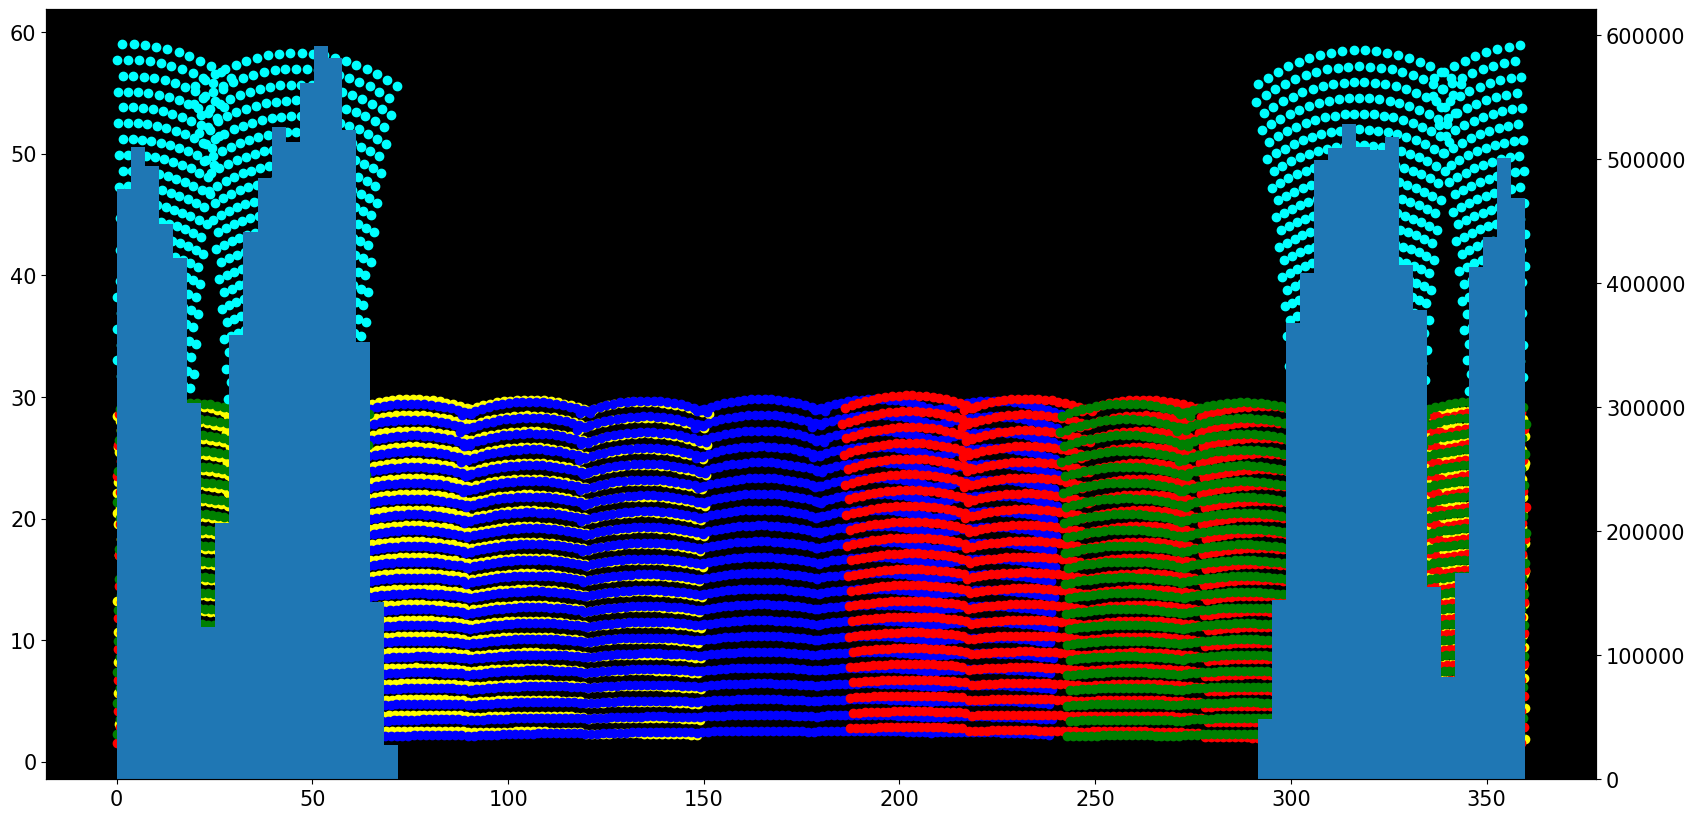

In [10]:
colors = ['yellow','blue','red','green','cyan']
plt.figure(figsize = [20,10])
plt.gca().set_facecolor('black')
for iEye in range(1,6):
    Mask = AllPossiblePixelDirections.EyeID == iEye
    Thetas = AllPossiblePixelDirections.Theta[Mask]
    Phis   = AllPossiblePixelDirections.Phi[Mask]
    plt.scatter(Phis,Thetas,c = colors[iEye-1])
    
ax2 = plt.gca().twinx()
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0
AllThetas = Dataset.get_pixel_values('Theta')
# plt.hist(AllThetas,bins=100)
AllPhis   = Dataset.get_pixel_values('Phi')
X = AllPhis+HE_BackwallAngle
X[X>360] -= 360
ax2.hist(X,bins=100)
plt.show()

### First Check the Pixel Indices definitions, and see if IndexToXY needs to be adjusted

In [10]:
print(Dataset.Pixel_level_keys.keys())
PixelIndices = Dataset.get_pixel_values('PixelID').to(torch.int64)
PixelTelIDs = Dataset.get_pixel_values('TelID').to(torch.int64)

PixelIndices_Adjusted = PixelIndices - (PixelTelIDs-1)*440 +1
UniquePixelIDs = torch.unique(PixelIndices_Adjusted)
print('Unique PixelID:',UniquePixelIDs)
print('Len Unique PixelID:',len(UniquePixelIDs))


dict_keys(['PixelID', 'TelID', 'EyeID', 'Status', 'Charge', 'Theta', 'Phi', 'TimeOffset', 'PulseStart', 'PulseCentroid', 'PulseStop'])
Unique PixelID: tensor([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
         15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
         43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,
         57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,
         71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
         85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140,
        141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 1

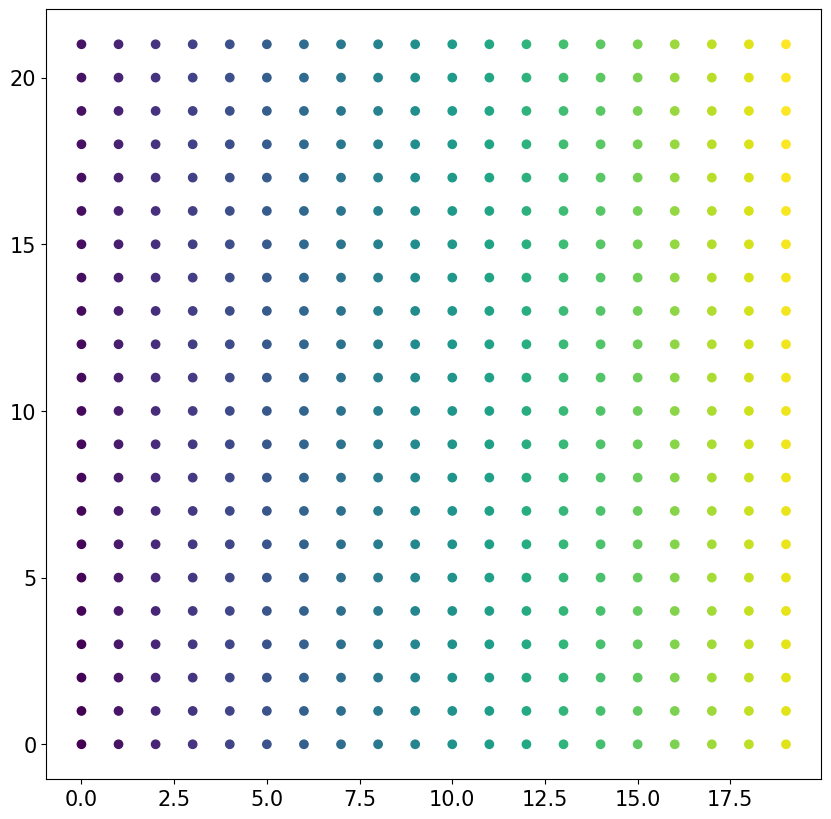

In [11]:
UniqueXs,UniqueYs = IndexToXY(UniquePixelIDs)
plt.figure()
plt.scatter(UniqueXs,UniqueYs,c=UniquePixelIDs)

### Check what the Truth Gen Function Should Be for the Cherenkov Fraction, etc.


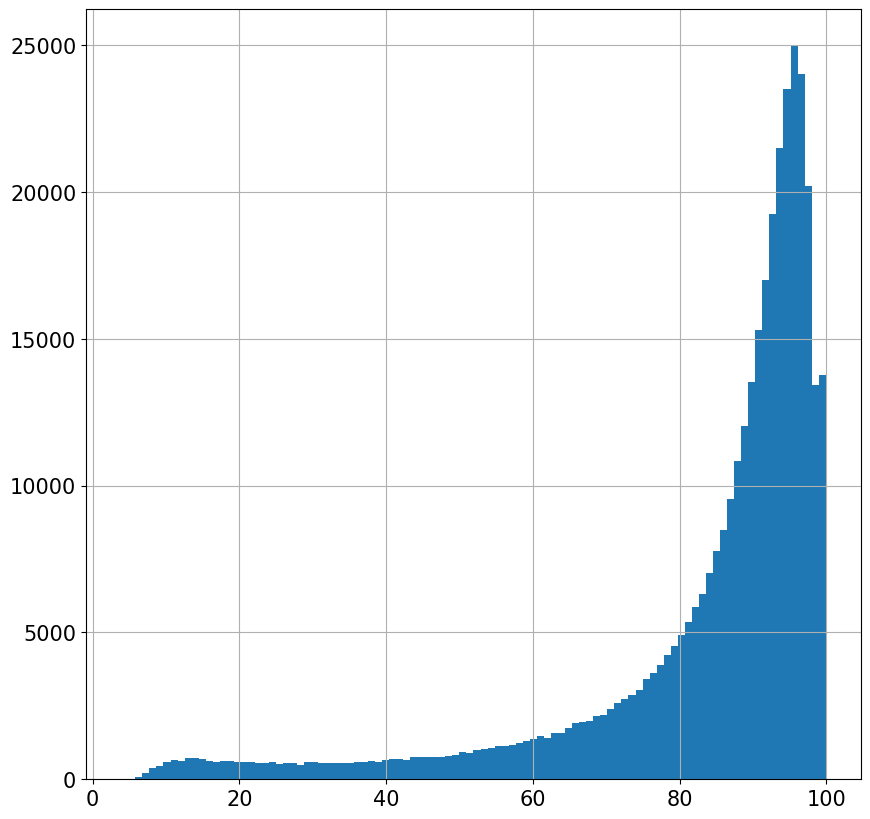

In [12]:
CherenkovFraction = Dataset.get_values('Gen_CherenkovFraction')

plt.figure()
plt.hist(CherenkovFraction,bins=100)
plt.grid()
plt.show()

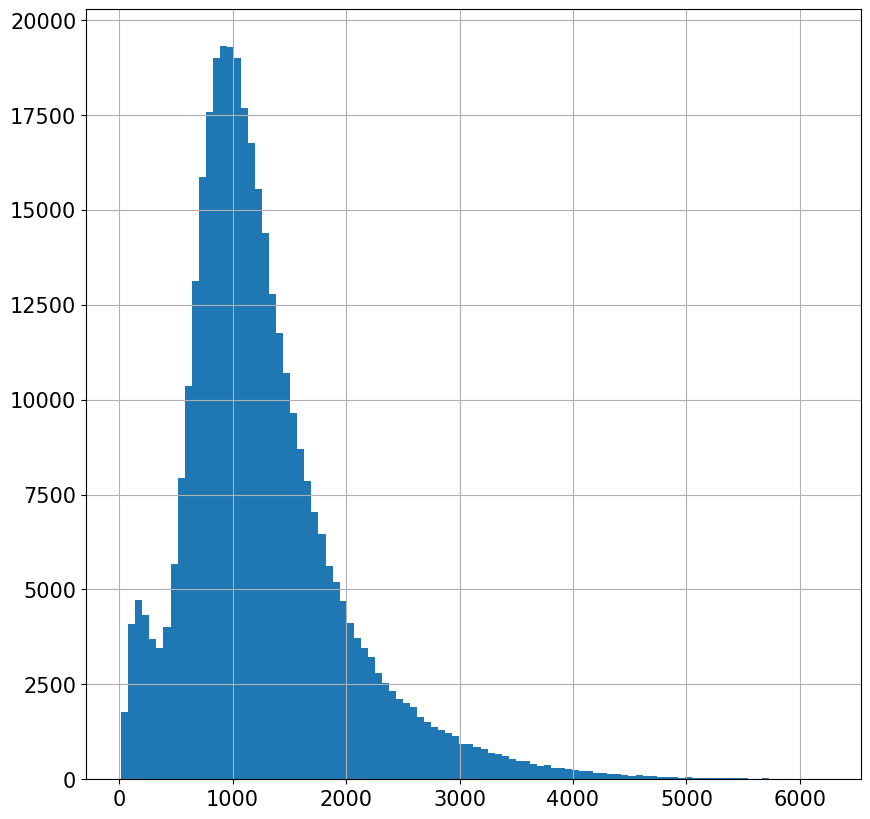

In [13]:
Val = 'Gen_Rp'
X = Dataset.get_values(Val)
                       
plt.figure()
plt.hist(X,bins=100)
plt.grid()

### Constructing Events for cherenkov Fraction
I want to know what the traces length is, check if i can have a good proppa 3d tensor fit thing

In [14]:
Blank_Event = Dataset.get_blank_event()
dir(Blank_Event)

['Event_level_keys',
 'HasTraces',
 'Number_of_pixels',
 'Pixel_level_keys',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_event_data',
 '_pixel_data',
 '_trace_data',
 'add_event_value',
 'add_from_dataset',
 'add_pixel_value',
 'add_trace_values',
 'clean_empty',
 'get_pixel_values',
 'get_trace_values',
 'get_value',
 'next_pixel']

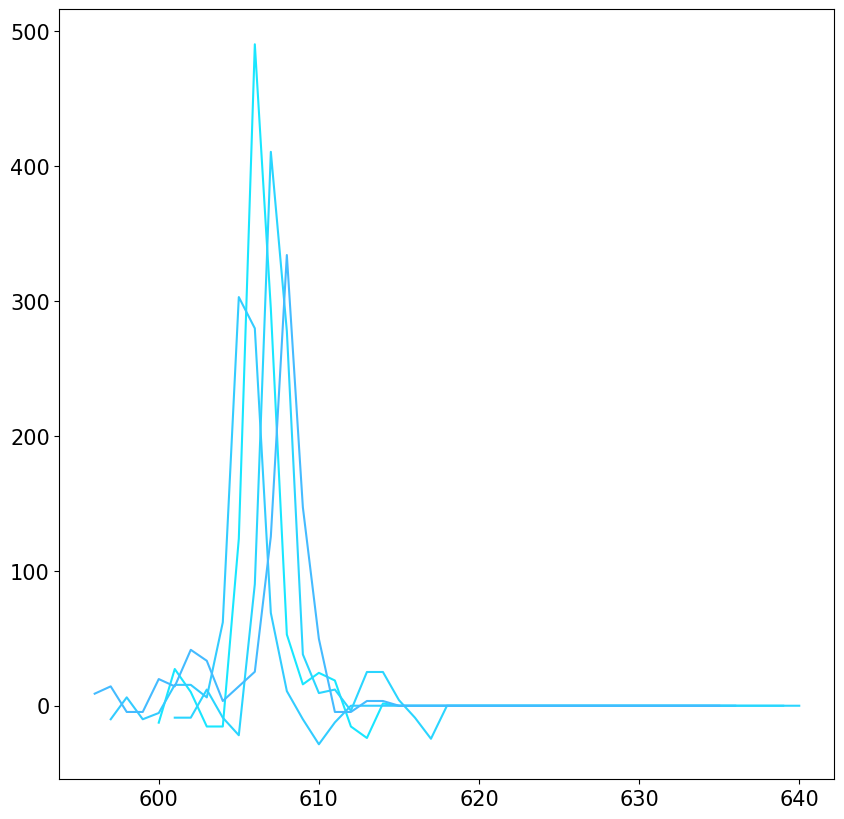

In [15]:
# Select Random Event
EvLength = 999
while EvLength > 40:
    N = np.random.randint(0,len(Dataset))
    Event = Dataset.get_event_by_index(N)
    EvLength = len(Event)


# Get Values
PixelStarts = Event.get_pixel_values('PulseStart')
PixelStatus = Event.get_pixel_values('Status')
PixelPulse   = Event.get_trace_values()


cmap = plt.get_cmap('cool')
plt.figure(figsize = (10,10))
for iPix in range(EvLength):
    # Plot
    plotXs = np.array(range(40))+ PixelStarts[iPix].int().item()
    plotYs = PixelPulse[iPix].numpy()
    
    Color = cmap(iPix/EvLength)
    if PixelStatus[iPix].int().item() ==  4 :
        plt.plot(plotXs,plotYs,color=Color)
    else:
        continue
        plt.plot(plotXs,plotYs,color=Color,linestyle = '--',alpha = 0.5)






In [16]:
All_EventDurations = []

for Event in Dataset:
    try:
        Pixel_PulseStart = Event.get_pixel_values('PulseStart')
        Pixel_PulseStop   = Event.get_pixel_values('PulseStop')
        Puxel_Status     = Event.get_pixel_values('Status')

        Pixel_PulseStart = Pixel_PulseStart[Puxel_Status == 4]
        Pixel_PulseStop   = Pixel_PulseStop[Puxel_Status == 4]
        Min_PulseStart = torch.min(Pixel_PulseStart)
        Max_PulseStop   = torch.max(Pixel_PulseStop)

        EventDuration = Max_PulseStop - Min_PulseStart
        All_EventDurations.append(EventDuration.item())
    except:
        continue


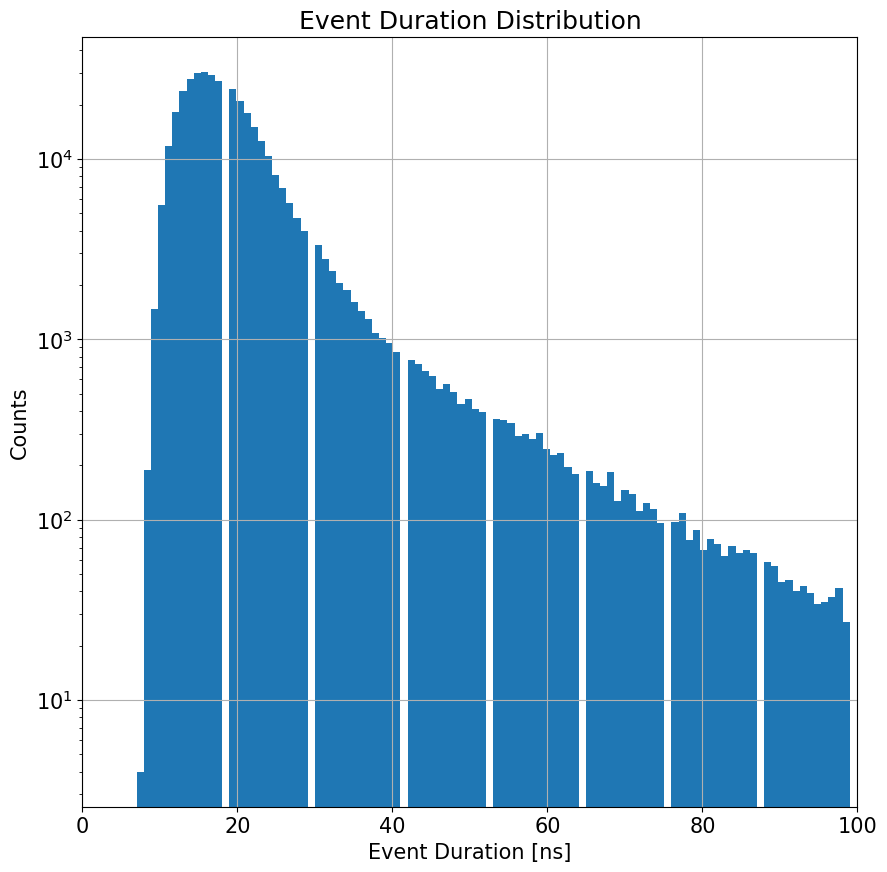

Fraction of Events with Duration >50 bins: 0.03
Fraction of Events with Duration >40 bins: 0.05
Fraction of Events with Duration >30 bins: 0.09
Fraction of Events with Duration >20 bins: 0.33
Fraction of Events with Duration >10 bins: 0.98


In [17]:
All_EventDurations = np.array(All_EventDurations)
plt.figure()
plt.hist(All_EventDurations[All_EventDurations < 100],bins=100)
plt.grid()
plt.xlabel('Event Duration [ns]')
plt.ylabel('Counts')
plt.title('Event Duration Distribution')
plt.yscale('log')
plt.xlim(0,100)
plt.show()

print(f'Fraction of Events with Duration >50 bins: {np.sum(All_EventDurations > 50)/len(All_EventDurations):.2f}')
print(f'Fraction of Events with Duration >40 bins: {np.sum(All_EventDurations > 40)/len(All_EventDurations):.2f}')
print(f'Fraction of Events with Duration >30 bins: {np.sum(All_EventDurations > 30)/len(All_EventDurations):.2f}')
print(f'Fraction of Events with Duration >20 bins: {np.sum(All_EventDurations > 20)/len(All_EventDurations):.2f}')
print(f'Fraction of Events with Duration >10 bins: {np.sum(All_EventDurations > 10)/len(All_EventDurations):.2f}')

In [18]:
os.uname()

posix.uname_result(sysname='Linux', nodename='tedtop', release='6.11.0-26-generic', version='#26-Ubuntu SMP PREEMPT_DYNAMIC Sat Apr 12 11:25:41 UTC 2025', machine='x86_64')

### Constructing Data for SDP

In [19]:
# Append the path with the SDP directory

# Check if SDP directory is already in the path
if os.path.abspath('../SDP/Code/') in sys.path:
    print('SDP directory already in path')
else:
    sys.path.append(os.path.abspath('../SDP/Code/'))
    sys.path.append(os.path.abspath('../SDP/Models/'))


import SDP_Conv_DataGen
importlib.reload(SDP_Conv_DataGen)

from SDP_Conv_DataGen import Main_Conv2d_Grid_Charge_and_Time

In [20]:
Main = Main_Conv2d_Grid_Charge_and_Time(Dataset,None)

In [21]:
Dataset.Event_level_keys

{'EventID_1/2': 0,
 'EventID_2/2': 1,
 'Rec_Level': 2,
 'Event_Class': 3,
 'Primary': 4,
 'Gen_LogE': 5,
 'Gen_CosZenith': 6,
 'Gen_Xmax': 7,
 'Gen_dEdXmax': 8,
 'Gen_SDPPhi': 9,
 'Gen_SDPTheta': 10,
 'Gen_Chi0': 11,
 'Gen_Rp': 12,
 'Gen_T0': 13,
 'Gen_CoreEyeDist': 14,
 'Gen_CherenkovFraction': 15,
 'Rec_LogE': 16,
 'Rec_CosZenith': 17,
 'Rec_Xmax': 18,
 'Rec_dEdXmax': 19,
 'Rec_SDPPhi': 20,
 'Rec_SDPTheta': 21,
 'Rec_Chi0': 22,
 'Rec_Rp': 23,
 'Rec_T0': 24,
 'Rec_CoreEyeDist': 25,
 'Rec_CherenkovFraction': 26}

SDP_Theta: tensor(83.8627)
SDP_Phi: tensor(-13.4484)


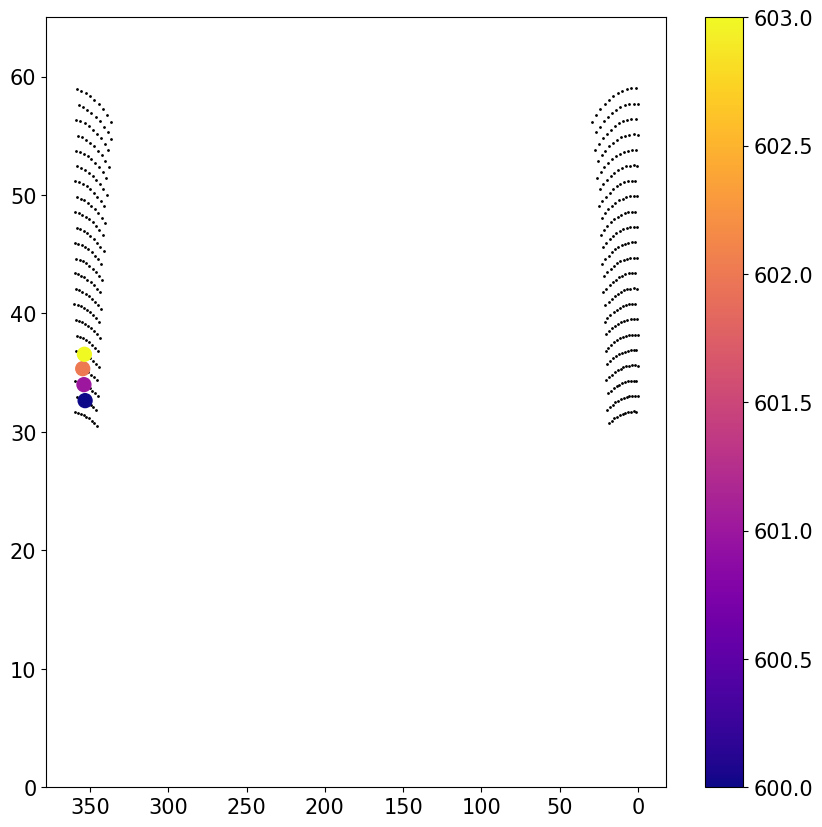

In [111]:
CO_BackwallAngle = 243.0219
HE_BackwallAngle = 273.0

# We randomly select event, until its SDPTheta are withing 10 degrees from 90
SDP_Theta = 0
while abs(SDP_Theta - np.pi/2) > 10*np.pi/180:
    N   = np.random.randint(0,10000)

    Event = Dataset.get_event_by_index(N)
    SDP_Theta = Event.get_value('Gen_SDPTheta')
SDP_Phi   = Event.get_value('Gen_SDPPhi')


All_pixel_Ids = Event.get_pixel_values('PixelID')
All_TelIDs    = Event.get_pixel_values('TelID')
All_Charge    = Event.get_pixel_values('Charge')
All_Times     = Event.get_pixel_values('PulseStart')
All_Status    = Event.get_pixel_values('Status')


WantedTelID = torch.unique(All_TelIDs)[0].item()

Mask = (AllPossiblePixelDirections['EyeID'] == 5) & (AllPossiblePixelDirections['TelID'] == WantedTelID)

All_Thetas = Event.get_pixel_values('Theta')
All_Phi    = Event.get_pixel_values('Phi')

SDP_Theta = Event.get_value('Gen_SDPTheta')
SDP_Phi   = Event.get_value('Gen_SDPPhi')

print('SDP_Theta:',SDP_Theta*180/np.pi)
print('SDP_Phi:',SDP_Phi*180/np.pi)

All_Phi_p = All_Phi + HE_BackwallAngle #- HE_BackwallAngle
All_Phi_p[All_Phi_p<0] += 360

AllPossiblePhi_p = AllPossiblePixelDirections[Mask]['Phi'] #- HE_BackwallAngle
AllPossiblePhi_p[AllPossiblePhi_p< 0] += 360

All_Phi_p[All_Phi_p>360] -= 360
AllPossiblePhi_p[AllPossiblePhi_p>360] -= 360


All_Phi_p = All_Phi_p   [All_Status == 4]
All_Thetas = All_Thetas [All_Status == 4]
All_Times = All_Times   [All_Status == 4]



plt.figure()
plt.scatter(AllPossiblePhi_p,AllPossiblePixelDirections[Mask]['Theta'],c='k',label='All Possible Directions',s=1)
plt.scatter(All_Phi_p       ,All_Thetas,c = All_Times,label='Event Directions',s=100,cmap = 'plasma')
plt.colorbar()
plt.ylim(0,65)
plt.gca().invert_xaxis()

TelID: 1, Average Phi: 43.92, Std: 12.53
TelID: 2, Average Phi: 89.34, Std: 12.65
TelID: 3, Average Phi: 132.30, Std: 12.48


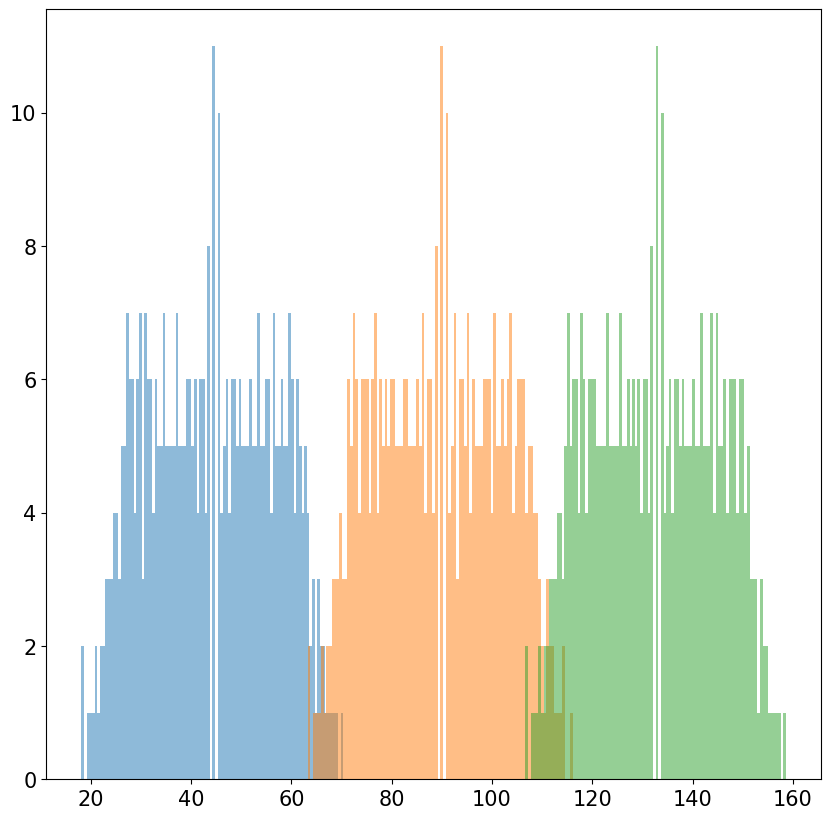

In [70]:
plt.figure()
for TelID in range(1,4):
    Mask = (AllPossiblePixelDirections['TelID'] == TelID) & (AllPossiblePixelDirections['EyeID'] == 5)
    # Print Average Phi for each Telescope
    All_Phi = AllPossiblePixelDirections[Mask]['Phi'] - HE_BackwallAngle
    All_Phi[All_Phi<0] += 360
    plt.hist(All_Phi,bins=100,alpha=0.5)
    print(f'TelID: {TelID}, Average Phi: {np.mean(All_Phi):.2f}, Std: {np.std(All_Phi):.2f}')

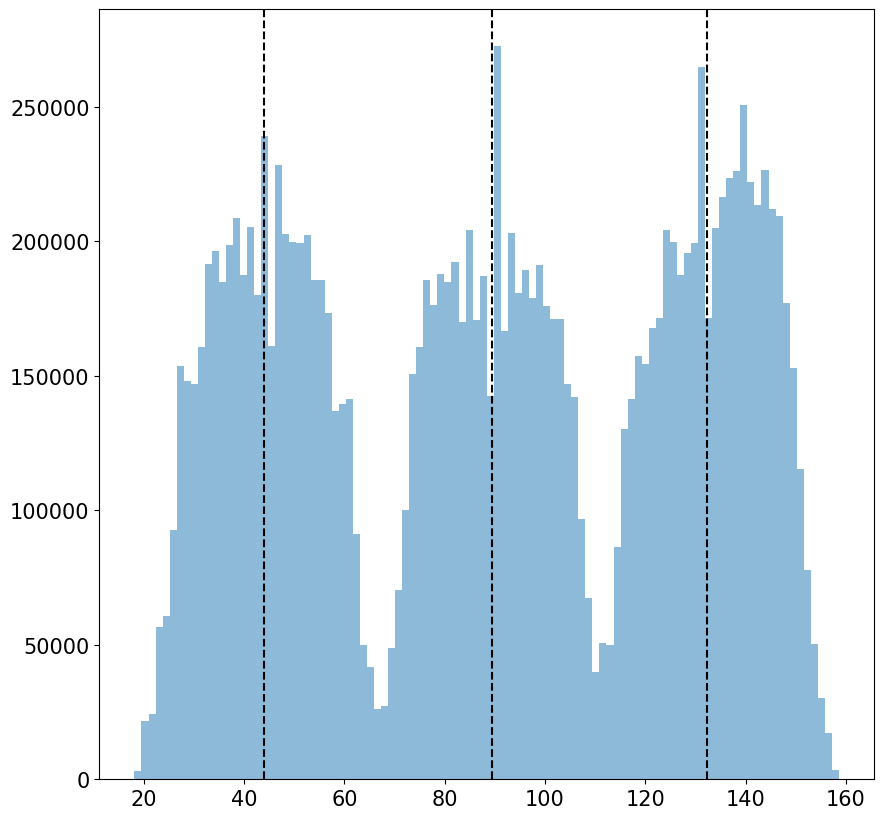

In [72]:
All_Phis = Dataset.get_pixel_values('Phi')
tel_offsets = { 1:43.92 , 2:89.34 , 3:132.30 }

plt.hist(All_Phis,bins=100,label='All Phis',alpha=0.5)
plt.axvline(tel_offsets[1],ls='--',color='k')
plt.axvline(tel_offsets[2],ls='--',color='k')
plt.axvline(tel_offsets[3],ls='--',color='k')



In [30]:
All_SDPThetas = []
All_SDPPhis   = []
tel_offsets = { 1:43.92 , 2:89.34 , 3:132.30 }
tel_offsets_zeroed = {1:43.92 -89.34, 2:0, 3:132.30 -89.34}

for iEv, Event in enumerate(Dataset):

    All_TelIDs = Event.get_pixel_values('TelID')
    The_TelID = torch.unique(All_TelIDs)[0].item()
    
    # if The_TelID != 2: continue
    All_SDPThetas.append(Event.get_value('Gen_SDPTheta'))
    All_SDPPhis.append(Event.get_value('Gen_SDPPhi') -tel_offsets_zeroed[The_TelID]/180*np.pi)
    
All_SDPThetas = np.array(All_SDPThetas)
All_SDPPhis   = np.array(All_SDPPhis)

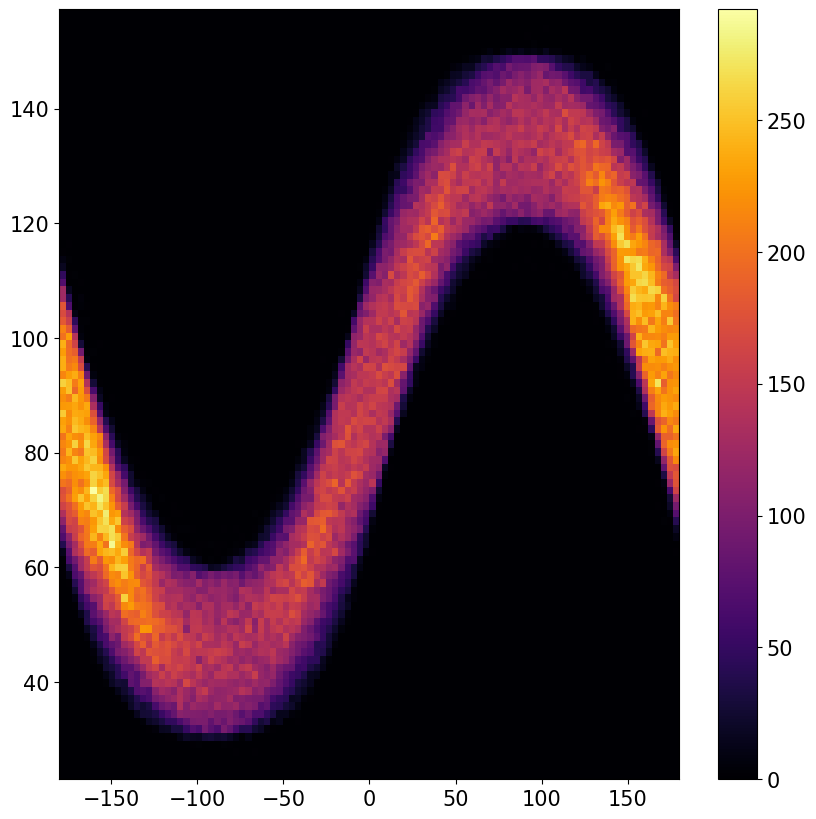

In [32]:
plt.figure()
X = All_SDPPhis   *180/np.pi
Y = All_SDPThetas *180/np.pi

X[X<-180] += 360
X[X>180] -= 360

plt.hist2d(X,Y,bins=100,cmap = 'inferno')
plt.colorbar()

Text(0.5, 0, 'Z')

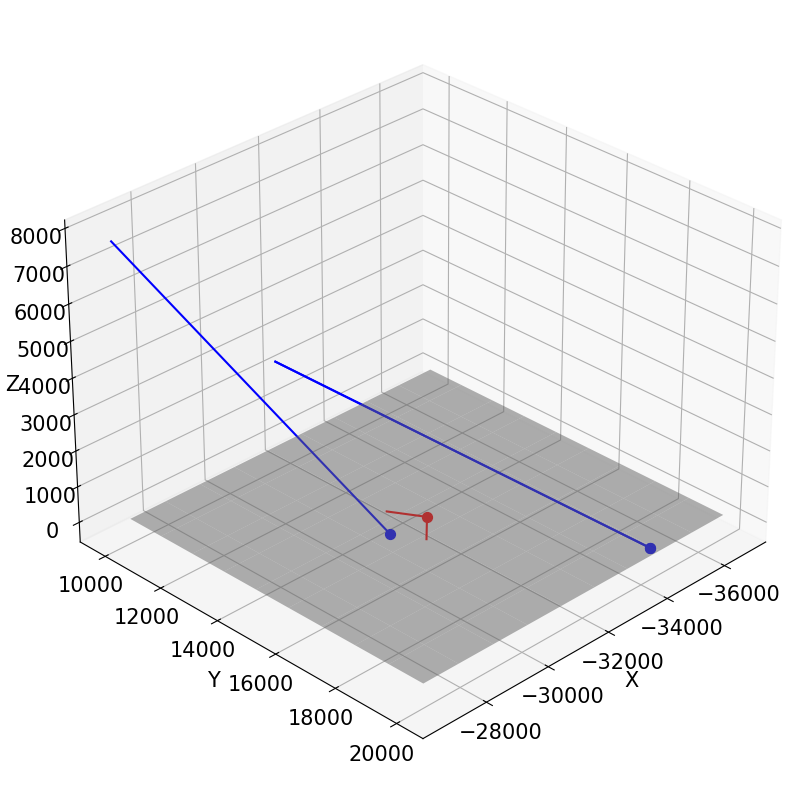

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# HEAT Position
x, y, z = -31741.12427975, 15095.57420328, 210.54774754
ax.scatter(x, y, z, color='red', s=50)


# Ground
size = 5000  # meters
# Create grid around the point in X and Y
xx, yy = np.meshgrid(
    np.linspace(x - size, x + size, 10),
    np.linspace(y - size, y + size, 10)
)
zz = np.full_like(xx, z)
ax.plot_surface(xx, yy, zz, color='gray', alpha=0.5)



# Shower axis
x0, y0, z0 = -30820, 14790, 0
ax.scatter(x0, y0, z0, color='blue', s=50)
zenith_deg = 40
azimuth_deg = 309.5
zenith = np.radians(zenith_deg)
azimuth = np.radians(azimuth_deg)
dx = np.sin(zenith) * np.cos(azimuth)
dy = np.sin(zenith) * np.sin(azimuth)
dz = np.cos(zenith)
length = 10000  # 10 km
x1 = x0 + dx * length
y1 = y0 + dy * length
z1 = z0 + dz * length
ax.plot([x0, x1], [y0, y1], [z0, z1], color='blue')

x0, y0, z0 = -34690, 19640, 0
ax.scatter(x0, y0, z0, color='blue', s=50)

# Direction from zenith and azimuth
zenith_deg = 62.9
azimuth_deg = 308

# Convert to radians
zenith = np.radians(zenith_deg)
azimuth = np.radians(azimuth_deg)
dx = np.sin(zenith) * np.cos(azimuth)
dy = np.sin(zenith) * np.sin(azimuth)
dz = np.cos(zenith)
length = 10000  # 10 km
x1 = x0 + dx * length
y1 = y0 + dy * length
z1 = z0 + dz * length
ax.plot([x0, x1], [y0, y1], [z0, z1], color='blue')

# Shower axis 2
x0, y0, z0 = -34690, 19640, 0
ax.scatter(x0, y0, z0, color='blue', s=50)

# Direction from zenith and azimuth
zenith_deg = 62.9
azimuth_deg = 308

# Convert to radians
zenith = np.radians(zenith_deg)
azimuth = np.radians(azimuth_deg)
dx = np.sin(zenith) * np.cos(azimuth)
dy = np.sin(zenith) * np.sin(azimuth)
dz = np.cos(zenith)
length = 10000  # 10 km
x1 = x0 + dx * length
y1 = y0 + dy * length
z1 = z0 + dz * length
ax.plot([x0, x1], [y0, y1], [z0, z1], color='blue')

# Telescope Limits
length = 1000
x0, y0, z0 = -31741.12427975, 15095.57420328, 210.54774754
zenith_deg = 90
azimuth_deg = 300

zenith = np.radians(zenith_deg)
azimuth = np.radians(azimuth_deg)
dx = np.sin(zenith) * np.cos(azimuth)
dy = np.sin(zenith) * np.sin(azimuth)
dz = np.cos(zenith)
x1 = x0 + dx * length
y1 = y0 + dy * length
z1 = z0 + dz * length
ax.plot([x0, x1], [y0, y1], [z0, z1], color='red')
zenith_deg = 90
azimuth_deg = 45

zenith = np.radians(zenith_deg)
azimuth = np.radians(azimuth_deg)
dx = np.sin(zenith) * np.cos(azimuth)
dy = np.sin(zenith) * np.sin(azimuth)
dz = np.cos(zenith)
x1 = x0 + dx * length
y1 = y0 + dy * length
z1 = z0 + dz * length
ax.plot([x0, x1], [y0, y1], [z0, z1], color='red')






ax.view_init(elev=30, azim=45)  # Adjust the view angle

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')



### End?